# Large Data Processing


Date: 2024.06.03


Carter Francis | csfrancis@wisc.edu

## What is Lazy Processing?

    A good way to think of lazy processing is: "let's try to build an effective plan to process my dataset from start to finish".... Without actually processing my data over and over again. 

    To do that you just make a nice list of things to do: 

    Or Better yet have the computer make that list for you!  This is what dask calls a "Task Graph" and you can see the graphs (if they are small... Hint: they will not be) by using:

```python
s.data.visualize()
```

    Typically a graph for a hyperspy signal will look like: 

<center><img src="images/mydask.png" style="height:400px"></center>

    Where first the array is initialized with the empty box and then the "array" function (circles are functions and squares/rectangles are parts of arrays called chunks) will load the data into memory. 

In [71]:
import numpy as np
import dask.array as da
from dask import optimize

In [72]:
# make both an in (and out of memory

In [4]:
# display the two arrays (What is different from one to the next?

In [3]:
# Visualize the task graph for the "out of memory array"

## Embaressingly Parallel

    This is an embaressingly parallel graph.  This doesn't mean you should be embarressed it just means that the computer should be embaressed if it isn't processing this in parallel. When you have straight lines everything is easy, nothing overlaps and you can give each seperate task to one core and it is happy!

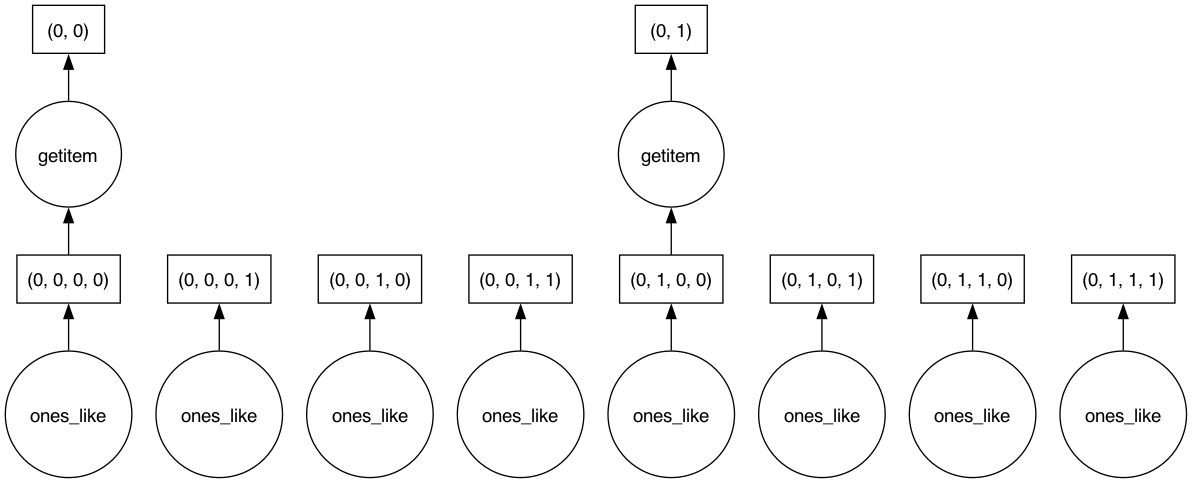

In [81]:
# What happens when I slice the data

In [5]:
# under the hood dask will call optimize before computing anything! Which will cull the tasks we don't really care about:

In [ ]:
# visualize the optimized graph
slice_arr_opt.visualize()

In [84]:
# Lets try to add the same dataset together!

In [6]:
# The task graphs are merged (and become more complicated!! But the data is only loaded once!)

## Chunking Datasets

    Chunking datasets is a little bit complicated. The general idea is that for a n dimensional array you want your chunks to span the dimensions that you are operating on.  In most cases this means that we want chunks in the "Signal Dimension" or the Reciporical Space Dimension. 

    Chunking Data can make your task graph more/ less complicated!



In [142]:
# create a new array with different chunks

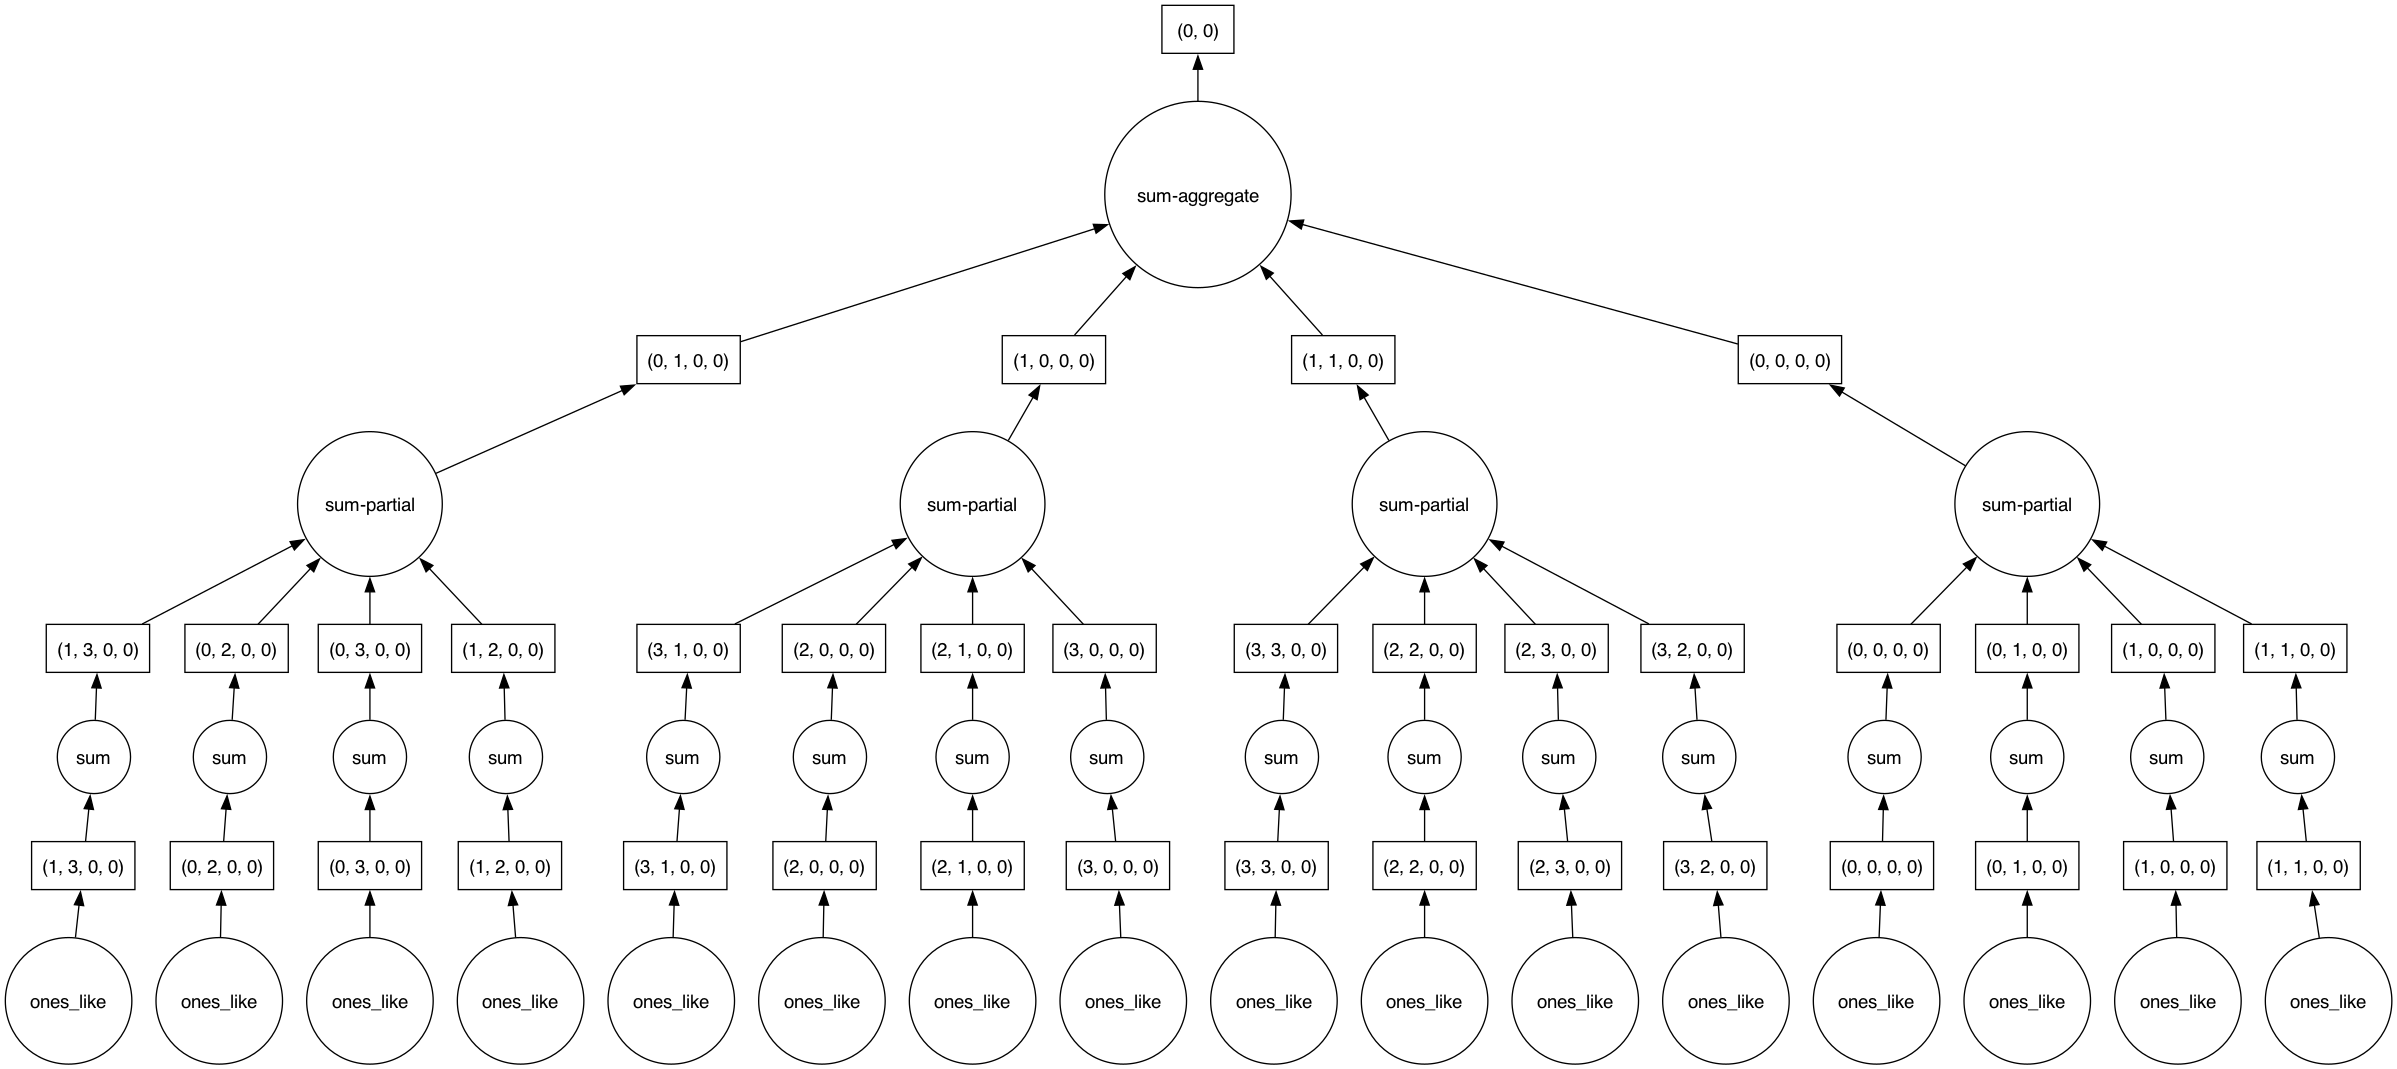

In [145]:
# Vizualize the task graph

In [8]:
# easier "fast" axis

In [398]:
from dask_image.ndfilters import gaussian_filter

In [9]:
# Show a nice embaressingly parrallel task graph :)

In [10]:
# show the task graph for overlapping computations!

## Loading Data

    Hyperspy + Rosettasciio lets you load data out of memory.  We extend the language that dask uses and call these Lazy signals:


```python
import hyperspy.api as hs
s = hs.load("your_dataset.whatever", lazy=True)
```

    For 4D STEM all file types should be able to be loaded lazily.  Not all file types run quickly and are good ways to store your data. In general:
    
    zarr > hdf5 > binary file.



In [149]:
import zarr
import pyxem as pxm
import hyperspy.api as hs

In [439]:
store = zarr.storage.ZipStore("../../../../carterfrancis/Library/Caches/pyxem/main/PdCuSiCrystalization-zip.zspy")
s =hs.load(store, lazy=True) # Make sure Lazy==True!
s.axes_manager.navigation_axes[0].name="x"
s.axes_manager.navigation_axes[1].name="y"
s.axes_manager.navigation_axes[2].name="time"

In [162]:
#s = pxm.data.pdcusi_insitu(allow_download=True, lazy=True)
#s.axes_manager.navigation_axes[0].name="x"
#s.axes_manager.navigation_axes[1].name="y"
#s.axes_manager.navigation_axes[2].name="time"

In [11]:
# Display the lazy dataset.  See the difference between how hyperspy represents data vs dask. 

In [12]:
# plot the data

In [13]:
# Create a Virtual Appature

In [14]:
# get a virtual image

In [15]:
# display the virtual image (this will be lazy)

In [16]:
# compute the navigator

In [17]:
# set the navigator for the signal s (Note things are __much__ faster plotting now!)

## Let's Visualize Some Stuff!

    Underlying dask there are a couple of different schedulers which are designed to evaluate different workflows.  I personally like the distributed scheduler.  Because hyperspy uses dask under the hood to do basic operations you can just switch the dask scheduler and that will switch hyperspy/ pyxem's as well! 

#### Starting a distributed cluster the easy way:

This just starts a local cluster on your laptop or desktop

```python 
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client
```

#### Starting a distributed cluster the moderately hard way

This starts a cluster running on multiple computers on a HPC cluster using the Slurm scheduler. 

```python 
from dask_jobqueue import SLURMCluster

# you can also use smaller jobs which might get scheduled faster
cluster = SLURMCluster(cores=40,
                       memory ='120GB',
                       walltime="02:00:00", queue='research',)  # Each job takes up one entire Node on the compute cluster

from dask.distributed import Client
cluster.scale(job=5)# ask for 5 nodes
client = Client(cluster) # this client now has 200 cores and 600 GB of RAM  to do whatever we want!
```

## Let's Try It:

    Follow the link to see the dask-dashboard which will show you the memory and workers avilable for your laptop.

In [18]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [19]:
# plot the data

In [20]:
# close the plots (just to make sure things don't get too slow...)

In [21]:
# Show how the compute function works buy summing the data

## Center the Direct Beam


Let's look at a simple embaressingly parallel workflow

In [22]:
# Get the direct beam

In [23]:
# compute the direct beam position

In [24]:
# make linear planes from the direct beam position

In [25]:
# center the direct beam

In [26]:
# pass the navigator so we don't have to deal with that

In [27]:
# save the centered data

In [28]:
# Reload the data (things are faster now because the task graph is smaller!)

## The Map Function (The secret to writing parallel and out of memory functions)


Inside of hyperspy is the map function which is a simple way to apply some function to every single signal axis. 

```python
from scipy.ndimage import maximum_filter
from skimage.morphology import disk
footprint = disk(r=4)
s.map(maximum_filter, footprint=footprint)
```


In [484]:
from scipy.ndimage import grey_opening
from skimage.morphology import disk 
footprint = disk(radius=2)
max_filter = s.map(grey_opening, footprint=footprint, inplace=False)

In [485]:
max_filter.navigator = s.navigator

In [486]:
max_filter.plot(vmax="99th")

## Processing this dataset

    Sometimes we might want to "improve" the signal to noise ratio of our data.  In this case the dataset was aquired at 40,000 fps so we might be interested in spatially blurring the dataset.  This greatly increases the signal to noise ratio at the cost of slightly lowering our spatial resolution. In most situations the trade off is worth it, especially if you are dealing with beam sensitive samples or dealing with limited signal due to aquisition constraints.

In [215]:
# filter the dataset


In [29]:
# pass the navigator

In [30]:
# template match a disk

In [31]:
# pass the navigator

In [32]:
# plot 

In [33]:
# close plots

In [34]:
# get the diffraciton vectors

In [248]:
m = dv.to_markers(facecolor="none", edgecolor="w", sizes=(20,))

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


In [264]:
# add the markers and plot them (lazily)

In [258]:
# lets just save a selection of the vectors [50:200]

In [260]:
# Lets try to do all of this processing and save some vectors!!!
# I appologize if I kill your computers here :)  The Gaussian filtering function 
# can be a little memory intensive as it is not embaressingly parallel!

#sliced_vectors.save("vectors.zspy", overwrite=True)

In [457]:
import hyperspy.api as hs

In [458]:
# reload the vectors (it's usually a good idea to save things periodically 
sliced_vectors = hs.load("vectors.zspy", lazy=True)

In [459]:
import numpy as np
def vector_virtual_image(vectors, vector_of_interest, max_distance):
    """Make a Virtual image from a single vector and intensity.
    """
    difference = vectors[:,:2]-vector_of_interest
    difference = np.abs(np.linalg.norm(difference, axis=1))
    is_within = difference<max_distance
    if vectors.shape[1] >2:
        intensity = vectors[is_within]
        if intensity.shape[0] ==0:
            return 0
        else:
            return np.mean(intensity[:,-1])
    else:
        return np.sum(is_within)

In [462]:
# create a map function to try this out
vdf = sliced_vectors.map(vector_virtual_image, vector_of_interest= [-2.8, 2.9], 
                   max_distance=0.65, inplace=False,
                   ragged=False, output_signal_size=(),
                   output_dtype=float)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


In [463]:
# transpose and set_signal_type
vdf = vdf.transpose((1,0))
vdf.set_signal_type("Signal2D")

In [465]:
#compute

WARNING | Hyperspy | `signal_type='Signal2D'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:743)


In [466]:
# inplace apply an opening morphological function to only account for large objects. 
from skimage.morphology import opening
vdf.data = opening(vdf.data )

In [467]:
vdf.plot()

WARNING | Hyperspy | `signal_type='Signal2D'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:743)


WARNING | Hyperspy | `signal_type='Signal2D'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:743)


## How Do I Find my Bottle Necks:

So this is probably the most important part of this talk.  

1. Things shouldn't be slow!  This dataset is ~22GB in size and it only took ~3-5 minutes to operate on it using a laptop that is 1 trying to conserve energy and 2 only has 8 cores.

2. We were never really limited by the I-O speed. (Even my laptop can load data at around 1 GB/sec!)
   
3. If your function is too slow open up a [discussion](https://github.com/pyxem/pyxem/discussions) on pyxem  (most things should run in under 10 min on a desktop!)  I'd love to dicuss with you and help :) 

In [1]:
import hyperspy.api as hs
s= hs.load("centered.zspy", lazy=True)

In [28]:
s.save("centered2.zspy", overwrite=True)

/Users/carterfrancis/hyperspy-bundle/lib/python3.11/site-packages/rsciio/zspy/_api.py:216: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  store = zarr.storage.NestedDirectoryStore(


[########################################] | 100% Completed | 54.37 s
[########################################] | 100% Completed | 106.10 ms


In [12]:
from numcodecs import Blosc
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

In [19]:
s.data[s.data<30]=0

In [20]:
s.save("zero_trunc.zspy")

[                                        ] | 0% Completed | 750.37 us

/Users/carterfrancis/hyperspy-bundle/lib/python3.11/site-packages/rsciio/zspy/_api.py:216: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  store = zarr.storage.NestedDirectoryStore(


[########################################] | 100% Completed | 57.36 s
[########################################] | 100% Completed | 102.21 ms


In [13]:
s.save("centered3.zspy", compressor=compressor, overwrite=True)

/Users/carterfrancis/hyperspy-bundle/lib/python3.11/site-packages/rsciio/zspy/_api.py:216: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  store = zarr.storage.NestedDirectoryStore(


[########################################] | 100% Completed | 95.82 s
[########################################] | 100% Completed | 106.11 ms


In [15]:
s2 = hs.load("centered3.zspy", lazy=True)

In [16]:
s2.sum().compute()

[########################################] | 100% Completed | 24.62 s


In [7]:
s.isig[50:60,50:60].sum().compute()

[########################################] | 100% Completed | 17.37 s


In [2]:
s.save("test.hspy", compression=None, overwrite=True)

[########################################] | 100% Completed | 42.55 s
[########################################] | 100% Completed | 105.92 ms


In [3]:
shspy = hs.load("test.hspy", lazy=True)

In [4]:
shspy.sum().compute()

[########################################] | 100% Completed | 32.64 s


In [9]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [10]:
#s.sum().compute()